# Using Polytope package

In [1]:
"""How to compute a polytope's volume."""
import numpy as np
import polytope

# constructing a convex polytope and computing its volume
vertices = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
hull = polytope.qhull(vertices)
    # `hull` is an instance of the class `polytope.polytope.Polytope`
    # which is for representing a convex polytope
print(hull.volume)

# constructing a nonconvex polytope and computing its volume
vertices_1 = np.array([[0.0, 0.0], [0.0, 1.0], [2.0, 1.0]])
vertices_2 = np.array([[0.0, 1.0], [1.0, 1.0], [1.0, 2.0], [0.0, 2.0]])
hull_1 = polytope.qhull(vertices_1)  # convex hull of vertices in `vertices_1`
hull_2 = polytope.qhull(vertices_2)  # convex hull of vertices in `vertices_2`
nonconvex = hull_1.union(hull_2)  # construct union of convex polytopes
    # `nonconvex` is an instance of the class `polytope.polytope.Region`
    # which is for representing any polytope, including nonconvex ones,
    # and in this case can also be constructed with
    # `polytope.polytope.Region([hull_1, hull_2])`
print(polytope.volume( nonconvex ))

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


0.476
2.0120000000000005


In [2]:
polytope.volume(nonconvex, nsamples=50000)

2.0120000000000005

In [3]:
nonconvex.volume

2.0120000000000005

# Find Ellipse with cvxpy

In [4]:
import polytope as pt
# problem data
n = 2;
points = np.array
px = np.array([0, .5, 2, 3, 1]).reshape(-1,1);
py = np.array([0, 1, 1.5, .5, -.5]).reshape(-1,1);
points = np.append( px, py, axis=1 )
m = px.shape[1]
pxint = np.sum(px)/m; 
pyint = np.sum(py)/m;
px = np.append(px,  px[0])
py = np.append(py, py[0])

In [5]:
points

array([[ 0. ,  0. ],
       [ 0.5,  1. ],
       [ 2. ,  1.5],
       [ 3. ,  0.5],
       [ 1. , -0.5]])

In [6]:
 hull = pt.qhull(points)

In [7]:
A, b = hull.A, hull.b.reshape(-1,1)

In [8]:
A

array([[-0.44721, -0.89443],
       [-0.89443,  0.44721],
       [ 0.44721, -0.89443],
       [-0.31623,  0.94868],
       [ 0.70711,  0.70711]])

In [9]:
b

array([[0.     ],
       [0.     ],
       [0.89443],
       [0.79057],
       [2.47487]])

In [10]:
import cvxpy as cp
# formulate and solve the problem
B = cp.Variable((n,n), symmetric=True)
d = cp.Variable((n,1))
objective = cp.Maximize( cp.log_det( B ) )
const = []
for i in range( points.shape[0] ):
    const += [ cp.norm( B @ A[i,:].reshape(-1,1) ) + A[i,:].reshape(1,-1) @ d <= b[i,0] ]
prob = cp.Problem( objective, const )
prob.solve()

-0.09773305109039351

In [11]:
ellipse_n = 2
ellipse_num_planes = 5
ellipse_B = cp.Variable((ellipse_n,ellipse_n), symmetric=True)
ellipse_d = cp.Variable((ellipse_n,1))
ellipse_A = cp.Parameter((ellipse_num_planes,2))
ellipse_b = cp.Parameter((ellipse_num_planes,1))
ellipse_objective = cp.Maximize( cp.log_det( ellipse_B ) )
ellipse_const = []
for ellipse_i in range( ellipse_A.shape[0] ):
    ellipse_const += [ cp.norm( ellipse_B @ ellipse_A[ellipse_i,:]) + ellipse_A[ellipse_i,:] @ ellipse_d <= ellipse_b[ellipse_i,0] ]
ellipse_prob = cp.Problem( ellipse_objective, ellipse_const )

In [12]:
from cvxpylayers.jax import CvxpyLayer
import jax
cvxpylayer = CvxpyLayer(ellipse_prob, parameters=[ellipse_A, ellipse_b], variables=[ellipse_B, ellipse_d])
A_jax = A
b_jax = b

In [13]:
solution = cvxpylayer(A_jax, b_jax)

/home/hardik/Research/social-navigation/venv310/lib/python3.10/site-packages/cvxpylayers/jax/cvxpylayer.py:167: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sol[j].append(jnp.expand_dims(jnp.array(
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [14]:
solution

(Array([[1.15657, 0.17477],
        [0.17477, 0.81051]], dtype=float32),
 Array([[1.34374],
        [0.5    ]], dtype=float32))

In [15]:
solution[0]

Array([[1.15657, 0.17477],
       [0.17477, 0.81051]], dtype=float32)

In [16]:
import jax.numpy as jnp
new_fun = lambda A, b: jnp.sum(cvxpylayer(A, b)[0])

In [17]:
new_fun( A_jax, b_jax )

Array(2.31662, dtype=float32)

In [18]:
dcvxpylayer = jax.grad(lambda A, b: jnp.sum(cvxpylayer(A, b)[0]), argnums=[0, 1]) # sum of elements of B matrix
gradA, gradb = dcvxpylayer(A_jax, b_jax)

# dcvxpylayer_jit = jit(dcvxpylayer)
# dcvxpylayer_jit( A_jax, b_jax )



/home/hardik/Research/social-navigation/venv310/lib/python3.10/site-packages/cvxpylayers/jax/cvxpylayer.py:225: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  grad[j] += [jnp.expand_dims(jnp.array(


# Finding circle with cvxpy

In [19]:
r = cp.Variable()
c = cp.Variable((2,1))
objective2 = cp.Maximize(r)
const2 = []
for i in range( points.shape[0] ):
    const2 += [ A[i,:].reshape(1,-1) @ c + np.linalg.norm(A[i,:]) * r <= b[i,0] ]
prob2 = cp.Problem( objective2, const2 )
prob2.solve()

0.764084005211981

In [20]:
test = np.empty([2, 2])

In [21]:
test[0,0]

0.0

# Plot results

In [22]:
angles   = np.linspace( 0, 2 * np.pi, 100 )
ellipse_inner  = (B.value @ np.append(np.cos(angles).reshape(1,-1) , np.sin(angles).reshape(1,-1), axis=0 )) + d.value# * np.ones( 1, noangles );
ellipse_outer  = (2* B.value @ np.append(np.cos(angles).reshape(1,-1) , np.sin(angles).reshape(1,-1), axis=0 )) + d.value
circle_inner = c.value + r.value * np.append(np.cos(angles).reshape(1,-1) , np.sin(angles).reshape(1,-1), axis=0 )

3.576

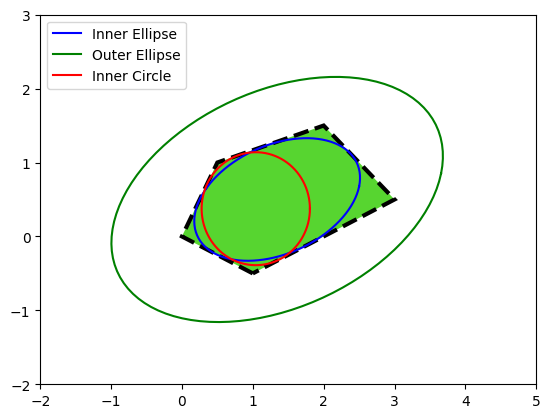

In [30]:
import matplotlib.pyplot as plt
plt.figure()
ax = plt.axes(xlim=(-2,5), ylim=(-2,3))
hull_plot = hull.plot(ax)
ax.plot( ellipse_inner[0,:], ellipse_inner[1,:], 'b', label='Inner Ellipse' )
ax.plot( ellipse_outer[0,:], ellipse_outer[1,:], 'g', label='Outer Ellipse' )
ax.plot( circle_inner[0,:], circle_inner[1,:], 'r', label='Inner Circle' )
ax.legend()
# hull_plot.clear()
hull.volume

# Polytope random function

In [31]:
import polytope as pc
A1 = np.array([[1.0, 0.0],
              [0.0, 1.0],
              [-1.0, -0.0],
              [-0.0, -1.0]])

b1 = np.array([2.0, 1.0, 0.0, 0.0])
p1 = pc.Polytope(A1, b1)

A2 = np.array([[1.0, 0.0],
              [0.0, 1.0],
              [-1.0, -0.0],
              [-0.0, -1.0]])

b2 = np.array([2.0, 1.0, 0.0, 0.0])
p2 = pc.Polytope(A2, b2)

In [32]:
p3 = p1.union(p2)

In [33]:
p3.volume

4.0

In [34]:
polytope.volume(p2)

2.0

In [35]:
import jax.numpy as jnp
from jax import jit, grad
import jax
from jax import config
config.update("jax_enable_x64", True)

In [36]:
jnp.heaviside(jnp.array([1,2,-1]), 1.0)

Array([1., 1., 0.], dtype=float64)

In [37]:
key = jax.random.PRNGKey(10)

In [38]:
# @jit
def mc_polytope_volume_org(A, b, samples, bound1, bound2):
    aux = A @ samples - b
#     print(f"old:{jnp.nonzero(jnp.all(aux < 0, 0))}")
#     return jnp.sum(jnp.nonzero(jnp.all(aux < 0, 0))[0])
    aux = jnp.nonzero(jnp.all(aux < 0, 0))[0].shape[0]    
    vol = (bound1 * bound2) * aux / num_samples
    print(f"aux: {aux}")
    return vol
mc_polytope_volume_org_grad = grad(mc_polytope_volume_org, 0)
# @jit

@jit
def mc_polytope_volume(A, b, samples, bound1, bound2):
#     key = jax.random.PRNGKey(10)
#     num_samples=50000
#     bounds = 30
#     samples = jax.random.uniform( key, shape=(2,num_samples), minval=-bounds, maxval=bounds )#A.shape[1]   
    aux = A @ samples - b    
    aux = -aux
    aux = jnp.min(aux, axis=0)
    aux = (jnp.tanh( aux / 0.001 ) + 1.0)/2.0    
    aux = jnp.sum( aux )
    vol = (bound1 * bound2) * aux / num_samples
    return vol
mc_polytope_volume_grad = jit(grad(mc_polytope_volume, 0))

In [55]:
key, subkey = jax.random.split(key)
num_samples=50000
bounds = 30
poly_limits = hull.bounding_box
# samples = jax.random.uniform( key, shape=(2,num_samples), minval=-bounds, maxval=bounds, bound1 = 2*bounds, bound2=2*bounds )#A.shape[1]   
samples1 = jax.random.uniform( key, shape=(1,num_samples), minval=poly_limits[0][0,0], maxval=poly_limits[1][0,0] )#A.shape[1]  
samples2 = jax.random.uniform( key, shape=(1,num_samples), minval=poly_limits[0][1,0], maxval=poly_limits[1][1,0] )#A.shape[1]  
samples = jnp.append( samples1, samples2, axis=0 )

bound1 = poly_limits[1][0,0] - poly_limits[0][0,0]
bound2 = poly_limits[1][1,0] - poly_limits[0][1,0]
print(f"old volume : { mc_polytope_volume_org(hull.A, hull.b.reshape(-1,1), samples, bound1, bound2) }")
# print(f"old grad: { mc_polytope_volume_org_grad(hull.A, hull.b.reshape(-1,1), samples, bound1, bound2) }")
print(f"new volume: { mc_polytope_volume(hull.A, hull.b.reshape(-1,1), samples, bound1, bound2 ) } " )
print(f"new grad: { mc_polytope_volume_grad(hull.A, hull.b.reshape(-1,1), samples, bound1, bound2) }")
print(f"polytope library: {polytope.volume(hull, nsamples=50000)}")

aux: 32869
old volume : 3.94428
new volume: 3.9442259708689646 
new grad: [[-0.60989  0.30483]
 [ 0.       0.     ]
 [ 0.       0.     ]
 [ 0.       0.     ]
 [-3.90315 -1.78898]]
polytope library: 3.576


In [40]:
hull.bounding_box[0][1,0]

-0.5

In [41]:
jnp.min(samples2)

Array(-0.49999, dtype=float64)

In [42]:
jnp.min( jnp.array([2.00554,1.03843,0.44378, 0.58484, 0.15283]) )
aa = jnp.array([[ 2.05088,  2.50971,  2.00554,  2.83296],
 [ 1.68793,  1.36946,  1.03843,  1.44821],
 [ 0.62205,  0.12897,  0.44378, -0.11737],
 [-0.02076,  0.3479 ,  0.58484,  0.32184],
 [-0.52535, -0.49707,  0.15283, -0.78026]])
jnp.min(aa, axis=0)

Array([-0.52535, -0.49707,  0.15283, -0.78026], dtype=float64)

In [43]:
hull.volume

3.576

In [44]:
# # @jit
# def mc_polytope_volume_jit(A, b, bounds = 30):
#     key = jax.random.PRNGKey(10)
#     num_samples=10000
#     volume = 0
#     samples = jax.random.uniform( key, shape=(A.shape[1],num_samples), minval=-bounds, maxval=bounds )
# #     print(f"A:{A}, samples:{samples}")
    
#     aux = A @ samples - b
#     aux = np.clip(-aux, a_min = 0 )
#     aux = np.nonzero(np.all(aux < 0, 0))[0].shape[0]
#     vol = (2*bounds)**2 * aux / num_samples
#     return vol

In [45]:
mc_polytope_volume_grad = grad(mc_polytope_volume, 0)

In [49]:
# mc_polytope_volume_grad( hull.A, hull.b.reshape(-1,1) )

In [ ]:
hull.b

In [ ]:
hull.A

In [ ]:
class Test:
    
    def __init__(self):
        self.test = 9
    
    
    def operate(self, x):
        return self.test * jnp.linalg.inv(x)
object = Test()

In [47]:
func = lambda x: object.operate(x)
func_jit = jit(func)

In [50]:
# %timeit  func(jnp.diag(jnp.array([2.0, 0.5])))

In [88]:
%timeit  func_jit(jnp.diag(jnp.array([2.0, 0.5])))

86.6 µs ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [89]:
func_jit(jnp.diag(jnp.array([2.0, 0.5])))

Array([[ 4.5,  0. ],
       [ 0. , 18. ]], dtype=float64)

In [90]:
object.test = 1

In [91]:
func_jit(jnp.diag(jnp.array([2.0, 0.5])))

Array([[ 4.5,  0. ],
       [ 0. , 18. ]], dtype=float64)

In [92]:
object.test

1

In [8]:
import numpy as np
a = np.array([[1,2],[5,6]])
b = np.array([[3,4],[9,10]])

In [9]:
a * b

array([[ 3,  8],
       [45, 60]])

In [10]:
np.sum(a * b)

116